# Coding a Multi-Layer Perceptron (MLP) model from scratch #

Having played a bit with deep-learning frameworks like Tensorflow, Keras and Pytorch, I decided to code a **Multi-Layer Perceptron** model *from scratch.*
To keep everything simple, I'll assume a single hidden layer (which can be generalized later to have as many layers as we want) as described in the following section.




# Model Description

The model that I'll implement is described in the following diagrams:
(source : https://documents.epfl.ch/users/f/fl/fleuret/www/dlc/)

## MLP Model - Forward Pass

![MLP forward pass](images/mlp_f.png)


## MLP Model - Backward Pass

![MLP Backward pass](images/mlp_b.png)


# Implementation


## Libraries & Imports

I'll use the [Pytorch](http://pytorch.org/) Tensor API (quite similar to NumPy) to implement it. I won't use any high-level torch.nn models but rather implement feed-forward and back-propagation algorithm myself. I could have used numpy to do it as well but I just want to use this opportunity to get more comfortable with low-level pytorch.

In [9]:
# Useful imports
import os
import torch
from torchvision import datasets

## Model Definition

The MLP Model will include following key methods:

* **init** : initializes model paramaters
* **forward** : conducts forward pass given feature vector
* **backward** : conducts backprop and generates the gradients
* **optimizsation step**: Updates the model parameters using the gradients and given learning rate
* **train**: Higher-level function to train the model using multiple epochs of 
  * Forward Pass
  * Backward Pass
  * Updating Model Parameters
* **evaluate** : Evaluates trained model using a test set
* **helper functions** : like activation, gradient of activation, loss, etc.

I have implemnted all of the above using a single Python class as follows:


In [16]:
# Multi-layer Perceptron Model as a class (with one hidden layer)
# Will try to generelize later with multiple hidden layers.

class MLPClassifier:
    def __init__(self, input_dim, output_dim, hidden_dim=20):
        # Initializing paramerters, gradients & intermediate variables 
        self.params, self.grads, self.intermediate = dict(), dict(), dict()
        self.params['w1'] = torch.normal(torch.zeros(input_dim, hidden_dim), torch.zeros(input_dim, hidden_dim).fill_(1e-6))
        self.params['b1'] = torch.normal(torch.zeros(1, hidden_dim), torch.zeros(1, hidden_dim).fill_(1e-6))
        self.params['w2'] = torch.normal(torch.zeros(hidden_dim, output_dim), torch.zeros(hidden_dim, output_dim).fill_(1e-6))
        self.params['b2'] = torch.normal(torch.zeros(1, output_dim), torch.zeros(1, output_dim).fill_(1e-6))
        self.grads_zero_()
  
    # Choosing tanh as activation function
    @staticmethod
    def sigma(x): return torch.tanh(x)
  
    # Derivative of tanh (x) = 1 - (tanh(x)) ^ 2
    @staticmethod
    def dsigma(x): return 1 - torch.tanh(x).pow(2)
  
    # Choosing MSE as loss function which works well in this case. Will explore
    # cross_entropy later
    @staticmethod
    def loss(v, t): return (v - t).pow(2).mean()
  
    # Derivative of MSE funcion
    @staticmethod
    def dloss(v, t): return 2 * (v - t)
  
  
    # Setting all gradients to zero (we'll do so before backward pass)
    def grads_zero_(self):
        self.grads['dl_dw1'] = torch.zeros_like(self.params['w1'])
        self.grads['dl_db1'] = torch.zeros_like(self.params['b1'])
        self.grads['dl_dw2'] = torch.zeros_like(self.params['w2'])
        self.grads['dl_db2'] = torch.zeros_like(self.params['b2'])

    # Forward Pass : Using the above diagram as reference
    def forward(self, x):
    
        # Model params
        w1 = self.params['w1']
        w2 = self.params['w2']
        b1 = self.params['b1']
        b2 = self.params['b2']
    
        # Calculating intermediate values and final value
        s1 = torch.matmul(x, w1) + b1
        x1 = self.sigma(s1)
        s2 = torch.matmul(x1, w2) + b2
        x2 = self.sigma(s2)
    
        # Caching intermediate values for backward pass
        self.intermediate['x']  = x
        self.intermediate['s1'] = s1
        self.intermediate['x1'] = x1
        self.intermediate['s2'] = s2
        self.intermediate['x2'] = x2
    
        # Return result calculated above
        return self.intermediate['x2']
  
    # Backward Pass : Using the above diagram and equations as reference
    def backward(self, t):
    
        # restoring cached values
        dl_dw1 = self.grads['dl_dw1']
        dl_dw2 = self.grads['dl_dw2']
        dl_db1 = self.grads['dl_db1']
        dl_db2 = self.grads['dl_db2']
        w2     = self.params['w2']
        x  = self.intermediate['x']
        s1 = self.intermediate['s1']
        x1 = self.intermediate['x1']
        s2 = self.intermediate['s2']
        x2 = self.intermediate['x2']
    
        #Calculate gradients
        dl_dx2 = self.dloss(x2, t)
        dl_ds2 = dl_dx2 * self.dsigma(s2)
        dl_dw2 += torch.mm(x1.t(), dl_ds2)
        dl_db2 += dl_ds2.sum(dim=0)
        dl_dx1 = torch.mm(dl_ds2, w2.t())
        dl_ds1 = dl_dx1 * self.dsigma(s1)
        dl_dw1 += torch.mm(x.t(), dl_ds1)
        dl_db1 += dl_ds1.sum(dim=0)
    
    # Function to update model params
    def optimize_step(self, lr=0.0001):
        self.params['w1'] -= lr * self.grads['dl_dw1']
        self.params['w2'] -= lr * self.grads['dl_dw2']
        self.params['b1'] -= lr * self.grads['dl_db1']
        self.params['b2'] -= lr * self.grads['dl_db2']
      
    # Function to train the model using a minibatch training set loader (pytorch specific)
    def train(self, train_loader, nb_epochs=10, lr=0.0001, verbose=True):
        for epoch in range(nb_epochs):
            losses, error = [], []
            for _, data in enumerate(train_loader):
        
                x0, y0 = data
                self.grads_zero_()      
        
                # Forward Pass
                out = self.forward(x0)
        
                if verbose: 
                    losses.append(self.loss(out, y0))
                    _, t = torch.max(y0, dim=1)
                    _, x = torch.max(out, dim=1)
                    error.append(torch.mean((t != x).float()))
        
                # Backward Pass
                self.backward(y0)
                # Optimization step
                self.optimize_step(lr)
        
            if verbose:
                trloss, trerr = sum(losses)/(len(losses)), sum(error)/len(error)
                print("-" * 60)
                print(f"Epoch : {epoch+1}: ")
                print(f"training loss : {trloss:.5f}, training error : {trerr*100:.3f}%")

    # Function to evaulate model performance on a test set
    def evaluate_test(self, test_loader):
        losses, error = [], []
    
        for data in test_loader:
            inputs, targets = data
            out = self.forward(inputs)
            losses.append(self.loss(out, targets))
            _, t = torch.max(targets, dim=1)
            _, x = torch.max(out, dim=1)
            error.append(torch.mean((t != x).float()))
    
        return sum(losses)/(len(losses)), sum(error)/len(error)

## Importing and Loading data

Although ideally I would keep this code in a separate module, I have included it here for the sake of completion.

Note: Instead of Input and Target tensors, I am using **Dataset Loaders** (pytorch specific) which generate mini-batches that will be used by the model defined above.

In [11]:
# Function to perform one-hot encoding of target values
def convert_to_one_hot_labels(input, target):
    tmp = input.new(target.size(0), target.max() + 1).fill_(-1)
    for k in range(0, target.size(0)):
        tmp[k, target[k]] = 1
    return tmp

# Function to load the mnist data and return mini-batch loaders to be used by the model
def load_mnist(one_hot_labels = False, normalize = False, flatten = True, batch_size=4):

    data_dir = os.environ.get('PYTORCH_DATA_DIR')
    if data_dir is None:
        data_dir = './data'

    mnist_train_set = datasets.MNIST(data_dir + '/mnist/', train = True, download = True)
    mnist_test_set = datasets.MNIST(data_dir + '/mnist/', train = False, download = True)

    train_input = mnist_train_set.train_data.view(-1, 1, 28, 28).float()
    train_target = mnist_train_set.train_labels
    test_input = mnist_test_set.test_data.view(-1, 1, 28, 28).float()
    test_target = mnist_test_set.test_labels

    if flatten:
        train_input = train_input.clone().view(train_input.size(0), -1)
        test_input = test_input.clone().view(test_input.size(0), -1)

    train_input = train_input.narrow(0, 0, 1000)
    train_target = train_target.narrow(0, 0, 1000)
    test_input = test_input.narrow(0, 0, 1000)
    test_target = test_target.narrow(0, 0, 1000)

    if one_hot_labels:
        train_target = convert_to_one_hot_labels(train_input, train_target)
        test_target = convert_to_one_hot_labels(test_input, test_target)

    if normalize:
        mu, std = train_input.mean(), train_input.std()
        train_input.sub_(mu).div_(std)
        test_input.sub_(mu).div_(std)

    train_target *= 0.9
    test_target *= 0.9
    
    train_dataset = torch.utils.data.TensorDataset(train_input, train_target)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(test_input, test_target)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

    return train_loader, test_loader, train_input.size(1), train_target.size(1)

In [12]:
train_loader, test_loader, input_dim, output_dim = load_mnist (one_hot_labels=True, normalize=True, flatten=True, batch_size=4)

## Training the MLP model

Train the model using 100 epochs...

In [17]:
model = MLPClassifier(input_dim, output_dim, hidden_dim=50)
model.train(train_loader, nb_epochs=500)

------------------------------------------------------------
Epoch : 1: 
training loss : 0.71964, training error : 89.900%
------------------------------------------------------------
Epoch : 2: 
training loss : 0.55784, training error : 89.000%
------------------------------------------------------------
Epoch : 3: 
training loss : 0.32199, training error : 90.200%
------------------------------------------------------------
Epoch : 4: 
training loss : 0.29493, training error : 88.300%
------------------------------------------------------------
Epoch : 5: 
training loss : 0.29380, training error : 89.200%
------------------------------------------------------------
Epoch : 6: 
training loss : 0.29350, training error : 88.300%
------------------------------------------------------------
Epoch : 7: 
training loss : 0.29335, training error : 88.400%
------------------------------------------------------------
Epoch : 8: 
training loss : 0.29319, training error : 88.700%
----------------

------------------------------------------------------------
Epoch : 69: 
training loss : 0.08135, training error : 9.500%
------------------------------------------------------------
Epoch : 70: 
training loss : 0.07858, training error : 9.400%
------------------------------------------------------------
Epoch : 71: 
training loss : 0.07614, training error : 9.200%
------------------------------------------------------------
Epoch : 72: 
training loss : 0.07370, training error : 8.900%
------------------------------------------------------------
Epoch : 73: 
training loss : 0.07149, training error : 7.900%
------------------------------------------------------------
Epoch : 74: 
training loss : 0.06928, training error : 7.900%
------------------------------------------------------------
Epoch : 75: 
training loss : 0.06730, training error : 7.800%
------------------------------------------------------------
Epoch : 76: 
training loss : 0.06540, training error : 7.400%
----------------

------------------------------------------------------------
Epoch : 137: 
training loss : 0.02344, training error : 1.800%
------------------------------------------------------------
Epoch : 138: 
training loss : 0.02318, training error : 1.800%
------------------------------------------------------------
Epoch : 139: 
training loss : 0.02293, training error : 1.700%
------------------------------------------------------------
Epoch : 140: 
training loss : 0.02267, training error : 1.700%
------------------------------------------------------------
Epoch : 141: 
training loss : 0.02244, training error : 1.600%
------------------------------------------------------------
Epoch : 142: 
training loss : 0.02219, training error : 1.600%
------------------------------------------------------------
Epoch : 143: 
training loss : 0.02195, training error : 1.600%
------------------------------------------------------------
Epoch : 144: 
training loss : 0.02174, training error : 1.600%
--------

------------------------------------------------------------
Epoch : 205: 
training loss : 0.01367, training error : 0.900%
------------------------------------------------------------
Epoch : 206: 
training loss : 0.01361, training error : 0.900%
------------------------------------------------------------
Epoch : 207: 
training loss : 0.01354, training error : 0.900%
------------------------------------------------------------
Epoch : 208: 
training loss : 0.01347, training error : 0.900%
------------------------------------------------------------
Epoch : 209: 
training loss : 0.01339, training error : 0.900%
------------------------------------------------------------
Epoch : 210: 
training loss : 0.01333, training error : 0.900%
------------------------------------------------------------
Epoch : 211: 
training loss : 0.01326, training error : 0.900%
------------------------------------------------------------
Epoch : 212: 
training loss : 0.01319, training error : 0.900%
--------

------------------------------------------------------------
Epoch : 273: 
training loss : 0.01046, training error : 0.800%
------------------------------------------------------------
Epoch : 274: 
training loss : 0.01043, training error : 0.800%
------------------------------------------------------------
Epoch : 275: 
training loss : 0.01040, training error : 0.800%
------------------------------------------------------------
Epoch : 276: 
training loss : 0.01037, training error : 0.800%
------------------------------------------------------------
Epoch : 277: 
training loss : 0.01034, training error : 0.700%
------------------------------------------------------------
Epoch : 278: 
training loss : 0.01031, training error : 0.700%
------------------------------------------------------------
Epoch : 279: 
training loss : 0.01028, training error : 0.700%
------------------------------------------------------------
Epoch : 280: 
training loss : 0.01025, training error : 0.700%
--------

------------------------------------------------------------
Epoch : 340: 
training loss : 0.00895, training error : 0.700%
------------------------------------------------------------
Epoch : 341: 
training loss : 0.00893, training error : 0.700%
------------------------------------------------------------
Epoch : 342: 
training loss : 0.00892, training error : 0.700%
------------------------------------------------------------
Epoch : 343: 
training loss : 0.00890, training error : 0.700%
------------------------------------------------------------
Epoch : 344: 
training loss : 0.00889, training error : 0.700%
------------------------------------------------------------
Epoch : 345: 
training loss : 0.00887, training error : 0.700%
------------------------------------------------------------
Epoch : 346: 
training loss : 0.00885, training error : 0.700%
------------------------------------------------------------
Epoch : 347: 
training loss : 0.00884, training error : 0.700%
--------

------------------------------------------------------------
Epoch : 408: 
training loss : 0.00795, training error : 0.500%
------------------------------------------------------------
Epoch : 409: 
training loss : 0.00794, training error : 0.500%
------------------------------------------------------------
Epoch : 410: 
training loss : 0.00792, training error : 0.500%
------------------------------------------------------------
Epoch : 411: 
training loss : 0.00790, training error : 0.500%
------------------------------------------------------------
Epoch : 412: 
training loss : 0.00788, training error : 0.500%
------------------------------------------------------------
Epoch : 413: 
training loss : 0.00787, training error : 0.500%
------------------------------------------------------------
Epoch : 414: 
training loss : 0.00785, training error : 0.500%
------------------------------------------------------------
Epoch : 415: 
training loss : 0.00783, training error : 0.500%
--------

------------------------------------------------------------
Epoch : 475: 
training loss : 0.00701, training error : 0.300%
------------------------------------------------------------
Epoch : 476: 
training loss : 0.00699, training error : 0.300%
------------------------------------------------------------
Epoch : 477: 
training loss : 0.00698, training error : 0.300%
------------------------------------------------------------
Epoch : 478: 
training loss : 0.00696, training error : 0.300%
------------------------------------------------------------
Epoch : 479: 
training loss : 0.00695, training error : 0.300%
------------------------------------------------------------
Epoch : 480: 
training loss : 0.00693, training error : 0.300%
------------------------------------------------------------
Epoch : 481: 
training loss : 0.00692, training error : 0.300%
------------------------------------------------------------
Epoch : 482: 
training loss : 0.00690, training error : 0.300%
--------

## Evaluating the model with a test set

Evaluating the performance of the model using the given test set...

In [7]:
l, e = model.evaluate_test(test_loader)
print(f"Test Error rate : {e*100:.3f}%")

Test Error rate : 14.400%


## Visualizing Sample Images and inferred labels

Now let's use the MLP model to determine labels of some sample images.

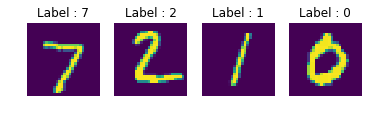

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

test_images, _ = next(iter(test_loader))
labels = model.forward(test_images)

fig, axes = plt.subplots(nrows=1, ncols=4)
for i,ax in enumerate(axes):
    _, label = torch.max(labels[i], dim=0)
    ax.imshow(test_images[i].view(28,28).numpy(), interpolation='nearest')
    ax.set_title(f"Label : {label[0]}")
    ax.set_axis_off()

# Conclusion

I really enjoyed this learning exercise.

My next steps will be to:

* Generalize the number of hidden layers
* Use regularization
* Include Btachnormalization
* Implement optimization algorithms like Adam etc.